In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline 
IS_LOCAL = False
import os
if(IS_LOCAL):
    PATH="/content/drive/MyDrive/rsna-pneumonia-detection-challenge"
else:
    PATH="/content/drive/MyDrive/rsna-pneumonia-detection-challenge"
print(os.listdir(PATH))

['.ipynb_checkpoints', 'stage_2_test_images', 'stage_2_train_images', 'stage_2_sample_submission.csv', 'stage_2_detailed_class_info.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_train_labels.csv', 'stage_2_test_png_images', 'stage_2_train_png_images', 'stage_2_train_labels.gsheet']


In [3]:


# Load the data
# Let's load the tabular data. There are two files:

# Detailed class info;
# Train labels.

class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')       

In [4]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [5]:
class_info_df.sample(10)

,patientId,class
12231,7d3f2d28-c21b-4a64-940c-c635176f35e1,Lung Opacity
12078,7bfcdf16-2730-4b80-bebb-d5889a8fa71e,Lung Opacity
17403,a679589b-9b88-4010-825a-cb3653587e78,Lung Opacity
11407,76b180ab-242f-45d3-bce1-68df00c5ef45,Normal
9468,67a495f5-4a1c-4176-9562-2657a7790eed,Normal
17524,a7467dcd-acd4-4237-97ce-21061ca2881f,No Lung Opacity / Not Normal
7195,54f4c62e-8ee3-458e-8468-8cc7b3042169,Lung Opacity
4284,3de25a4d-9c36-460f-96b9-2109faffc4dd,No Lung Opacity / Not Normal
23477,d369ac99-d05c-4b53-9fd3-c5a3b2709cc7,No Lung Opacity / Not Normal
6195,4cf82164-6678-4864-bbc4-5a93419424f7,Normal


In [6]:
train_labels_df.sample(10)

,patientId,x,y,width,height,Target
10068,6c481cad-cd2f-4688-aa41-da745b5540e1,NaN,NaN,NaN,NaN,0
8115,5cc79a07-54e7-4c37-9284-5d11fad4a8a2,NaN,NaN,NaN,NaN,0
28926,ff82e39d-608f-4f9d-b4db-f8598544e754,NaN,NaN,NaN,NaN,0
16569,a01997aa-d69a-435b-a000-c0c7b59dd97b,NaN,NaN,NaN,NaN,0
13883,8a9ff447-b0f1-4b0a-8185-17e310474b3f,NaN,NaN,NaN,NaN,0
6933,52d8daa8-bc19-4128-a8bd-60b6c0384ae2,NaN,NaN,NaN,NaN,0
18963,b16bcbb6-570b-450b-a9e5-b1e3663205bb,169.0,228.0,286.0,509.0,1
49,01b9e362-4950-40f5-88fa-7557ac2a45bb,366.0,289.0,208.0,527.0,1
20531,bbca9bd4-53b2-4076-a3b3-a1ee4079faec,634.0,735.0,187.0,220.0,1
4507,3f504abe-2133-4e09-98af-743cdea486f9,589.0,489.0,194.0,179.0,1


In class detailed info dataset are given the detailed information about the type of positive or negative class associated with a certain patient.

In train labels dataset are given the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia.

In [7]:
#Let's check missing information in the two datasets.

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_labels_df)

,x,y,width,height,patientId,Target
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [8]:
missing_data(class_info_df)

,patientId,class
Total,0.0,0.0
Percent,0.0,0.0


The percent missing for x,y, height and width in train labels represents the percent of the target 0 (not Lung opacity).

Let's check the class distribution from class detailed info.

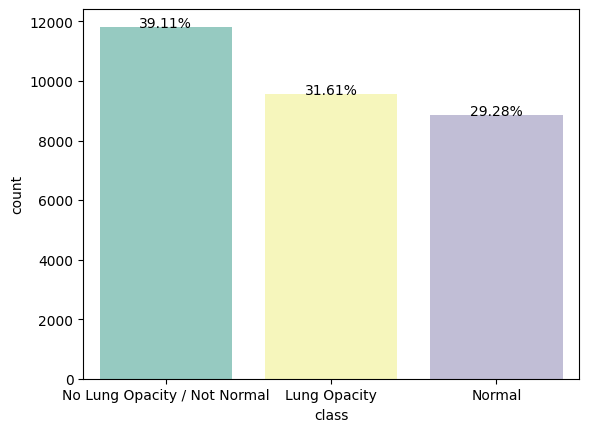

In [9]:
import seaborn as sns

class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')

# order the classes by count
class_order = class_info_df['class'].value_counts().index.tolist()

# plot the countplot with ordered classes and store the axis object
ax = sns.countplot(x='class', data=class_info_df, order=class_order, palette='Set3')

# add percentage labels to the plot
total = float(len(class_info_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 

plt.show()


In [10]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(class_info_df, 'class')


Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


No Lung Opacity / Not Normal and Normal have together the same percent (69.077%) as the percent of missing values for target window in class details information.

In the train set, the percent of data with value for Target = 1 is therefore 30.92%.

In [11]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [12]:
train_class_df.sample(5)

,patientId,x,y,width,height,Target,class
11251,624a95b9-354b-415e-8bcc-382c6510469d,281.0,345.0,200.0,538.0,1,Lung Opacity
21064,a3a3ff82-f299-42de-9807-c5272ba6ef9f,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
16396,84ece471-d23a-4b93-b6b3-92ce921f2eae,NaN,NaN,NaN,NaN,0,Normal
32599,e9c0814c-2d66-4265-a7f9-bd595a613ba6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
14010,74ccc60d-b6d1-43fa-b64b-a60402e8ed2b,NaN,NaN,NaN,NaN,0,Normal


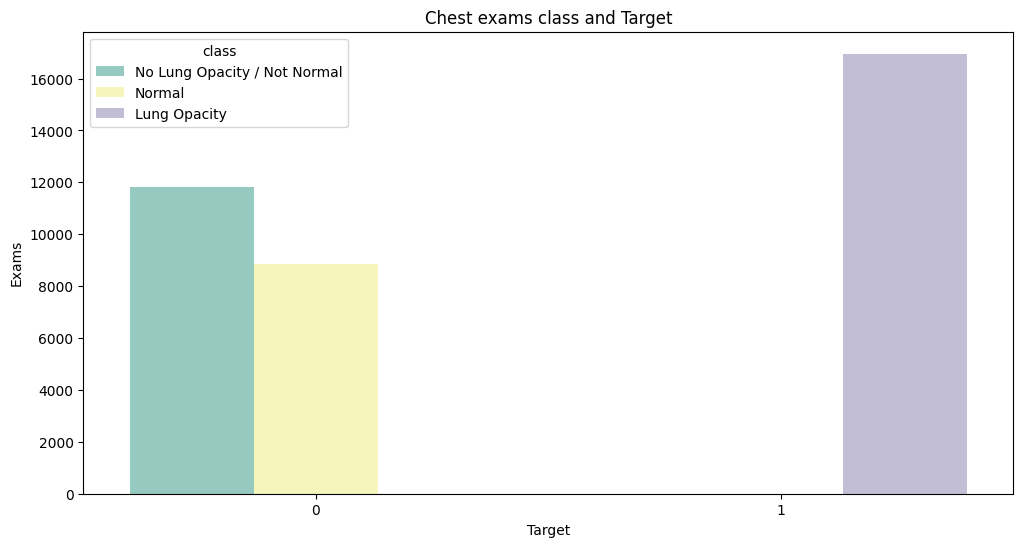

In [13]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

All chest examinations withTarget = 1 (pathology detected) associated with class: Lung Opacity.

The chest examinations with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal.

For the class Lung Opacity, corresponding to values of Target = 1, we plot the density of x, y, width and height.

<ipython-input-14-b293fc68349f>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
<ipython-input-14-b293fc68349f>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
<ipython-input-14-b29

<Figure size 640x480 with 0 Axes>

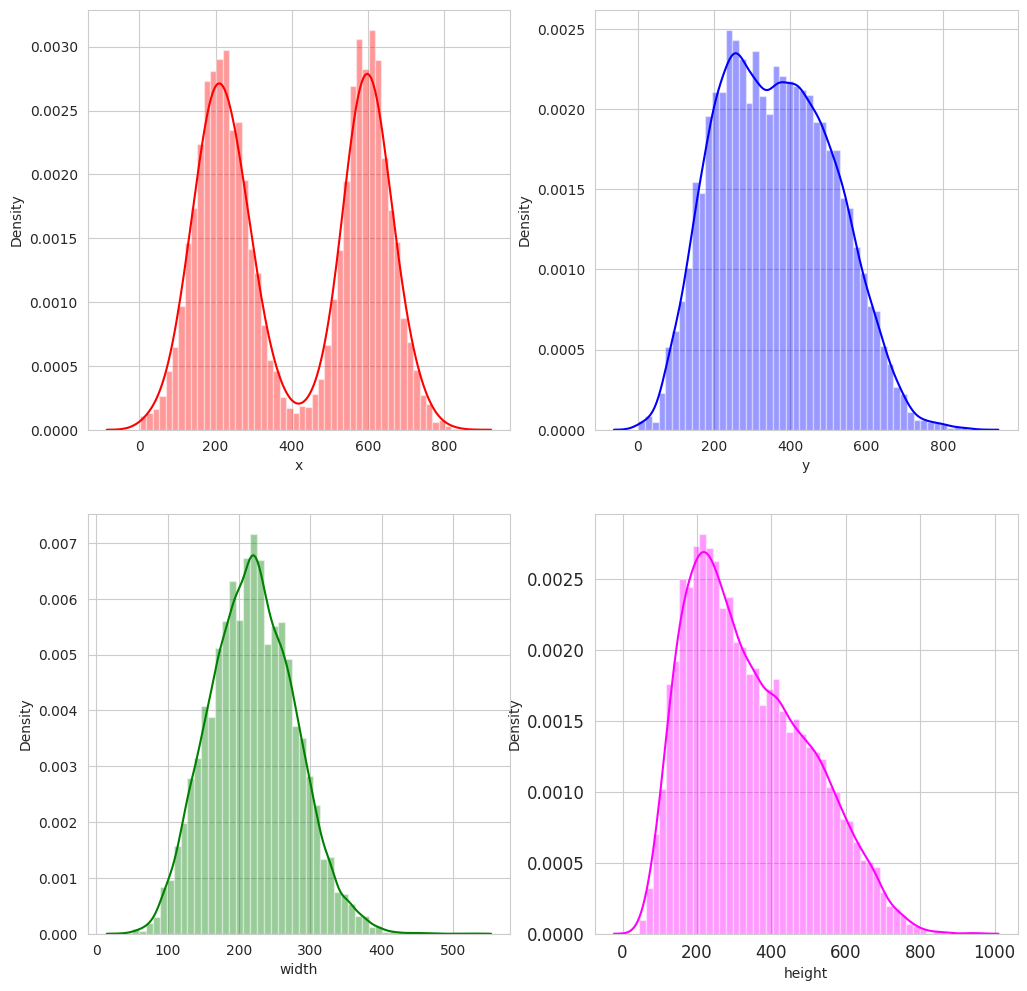

In [14]:
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

We will show a sample of center points superposed with the corresponding sample of the rectangles. The rectangles are created using the method described in Kevin's Kernel [1].

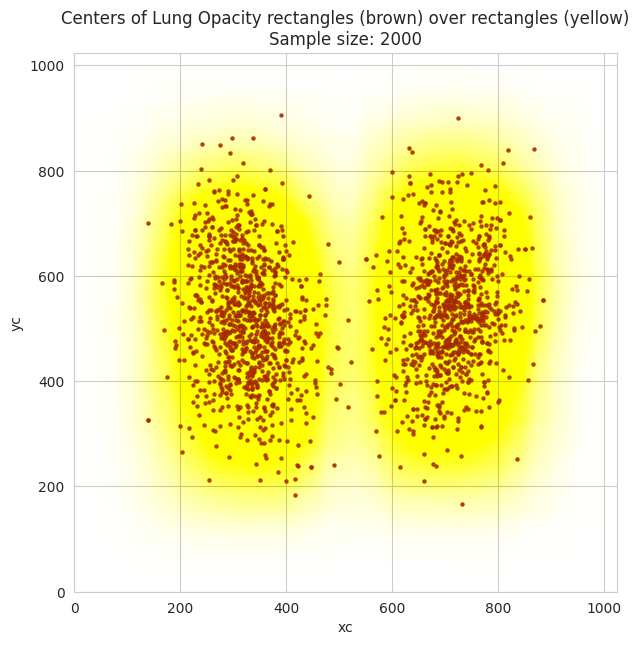

In [15]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [16]:
# explore dicom data
image_sample_path = os.listdir(PATH+'/stage_2_train_images')[:5]
print(image_sample_path)

['f80ad235-2e52-4952-bf33-73edfdb675f0.dcm', 'f7f55fde-fecd-4120-90fc-d018fbf10f84.dcm', 'f8279c3c-7906-4ac7-a2da-a2a94e4de519.dcm', 'f7a9a992-549e-47d4-8ffb-ba22fef38d8d.dcm', 'f7fcd6bd-940c-4ef9-94f1-8c322bf53586.dcm']


In [17]:
image_train_path = os.listdir(PATH+'/stage_2_train_images')
image_test_path = os.listdir(PATH+'/stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26704 
Number of images in test set: 3000


check for duplicate enteries

In [18]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())   

Unique patientId in  train_class_df:  26684


In [19]:
#We confirmed that the number of unique patientsId are equal with the number of DICOM images in the train set.

# Let's see what entries are duplicated. We want to check how are these distributed accross classes and Target value.

In [20]:
tmp = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

,Exams,Target,Class,Entries
0,1,0,No Lung Opacity / Not Normal,11821
1,1,0,Normal,8851
2,1,1,Lung Opacity,2614
3,4,1,Lung Opacity,3266
4,9,1,Lung Opacity,119
5,16,1,Lung Opacity,13


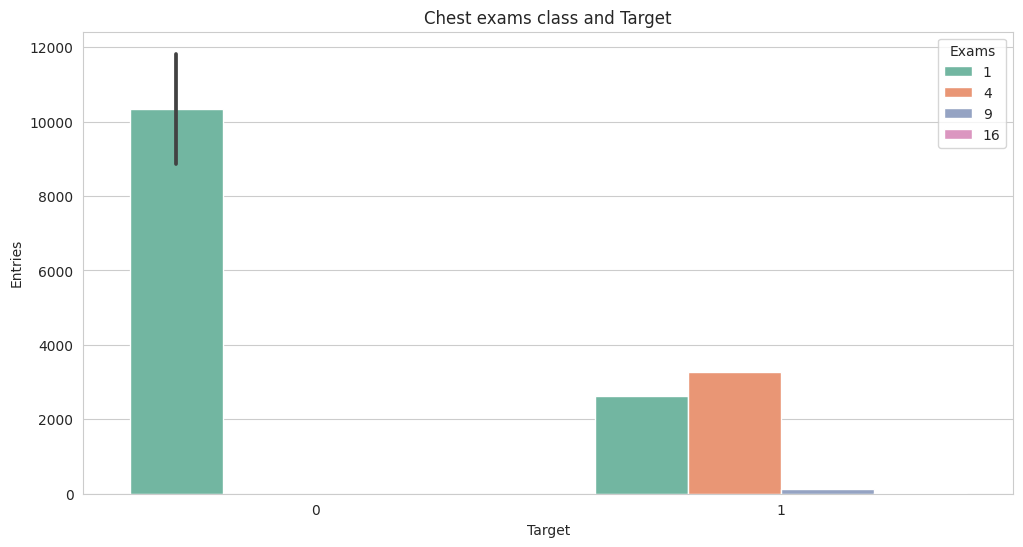

In [21]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
sns.barplot(ax=ax,x = 'Target', y='Entries', hue='Exams',data=df2, palette='Set2')
plt.title("Chest exams class and Target")
plt.show()

In [22]:
#Let's now extract one image and process the DICOM information.

In [23]:
#dicom meta data

In [24]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(PATH,"stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [25]:
#plot dicom images with target 1
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

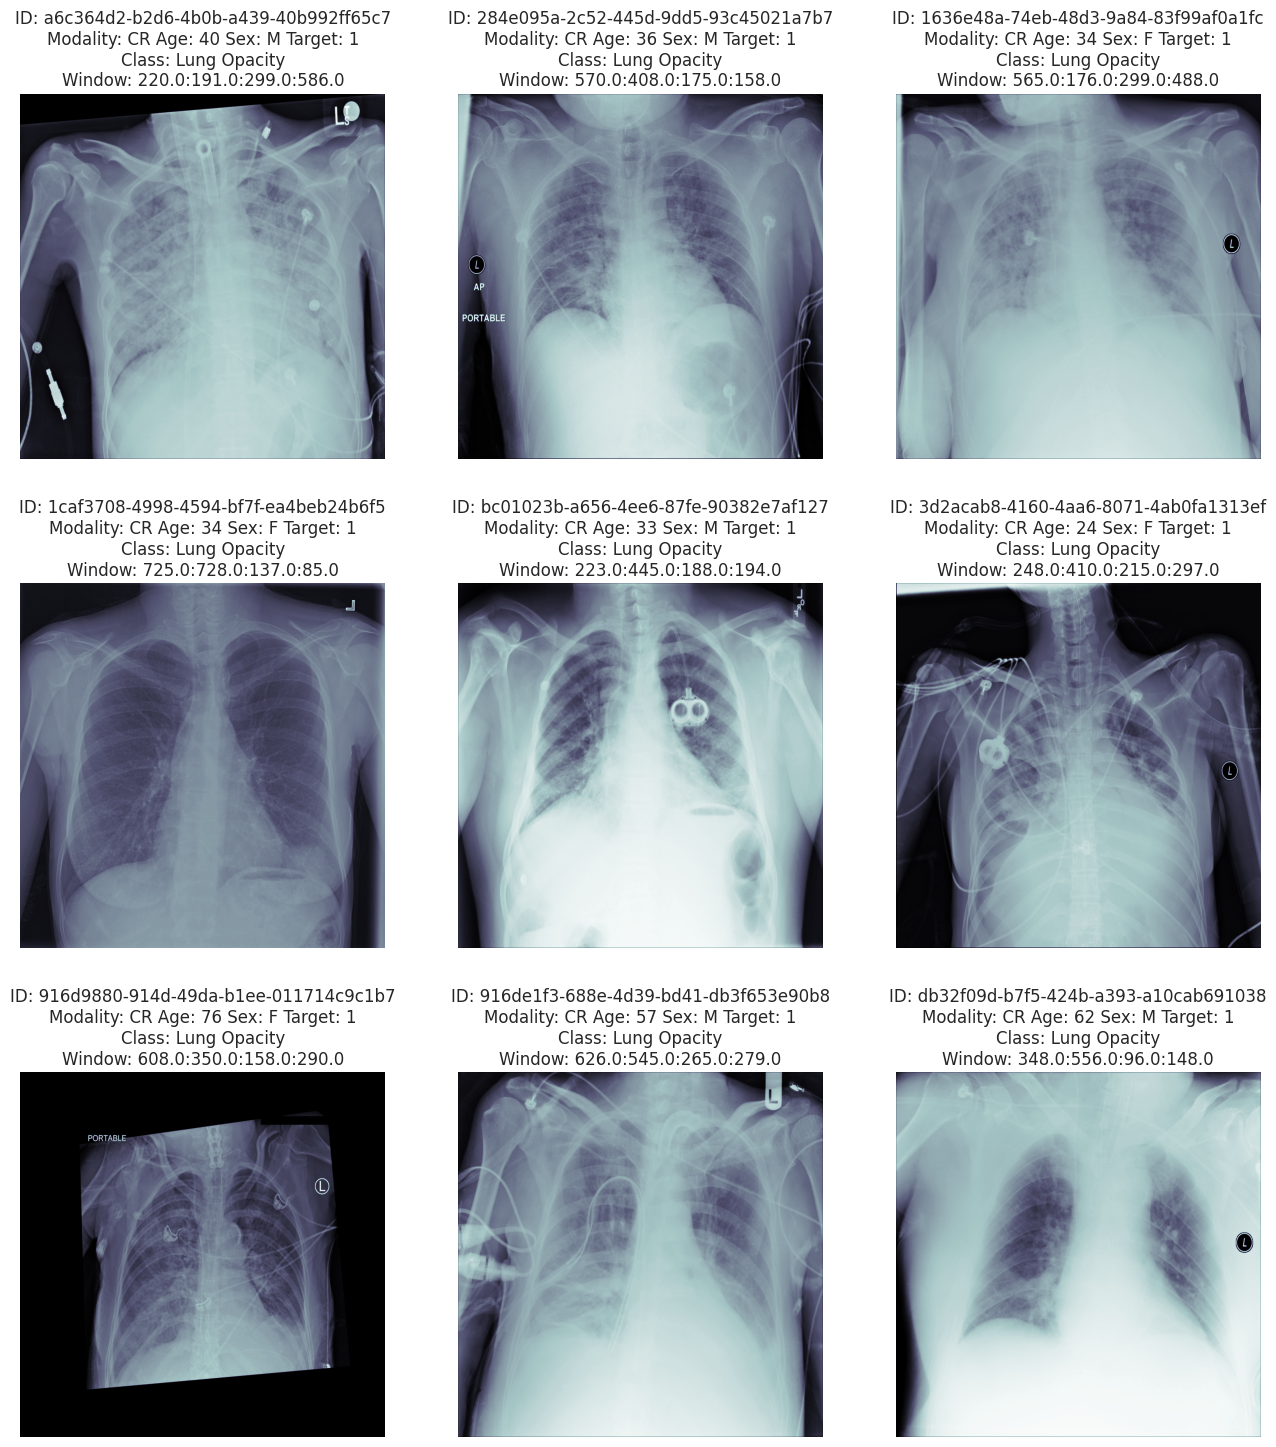

In [26]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

In [27]:
#We would like to represent the images with the overlay boxes superposed. For this, we will need first to parse the whole dataset with 
# Target = 1 and gather all coordinates of the windows showing a Lung Opacity on the same image. The simples method is show in [1] and 
# we will adapt our rendering from this method.

In [28]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

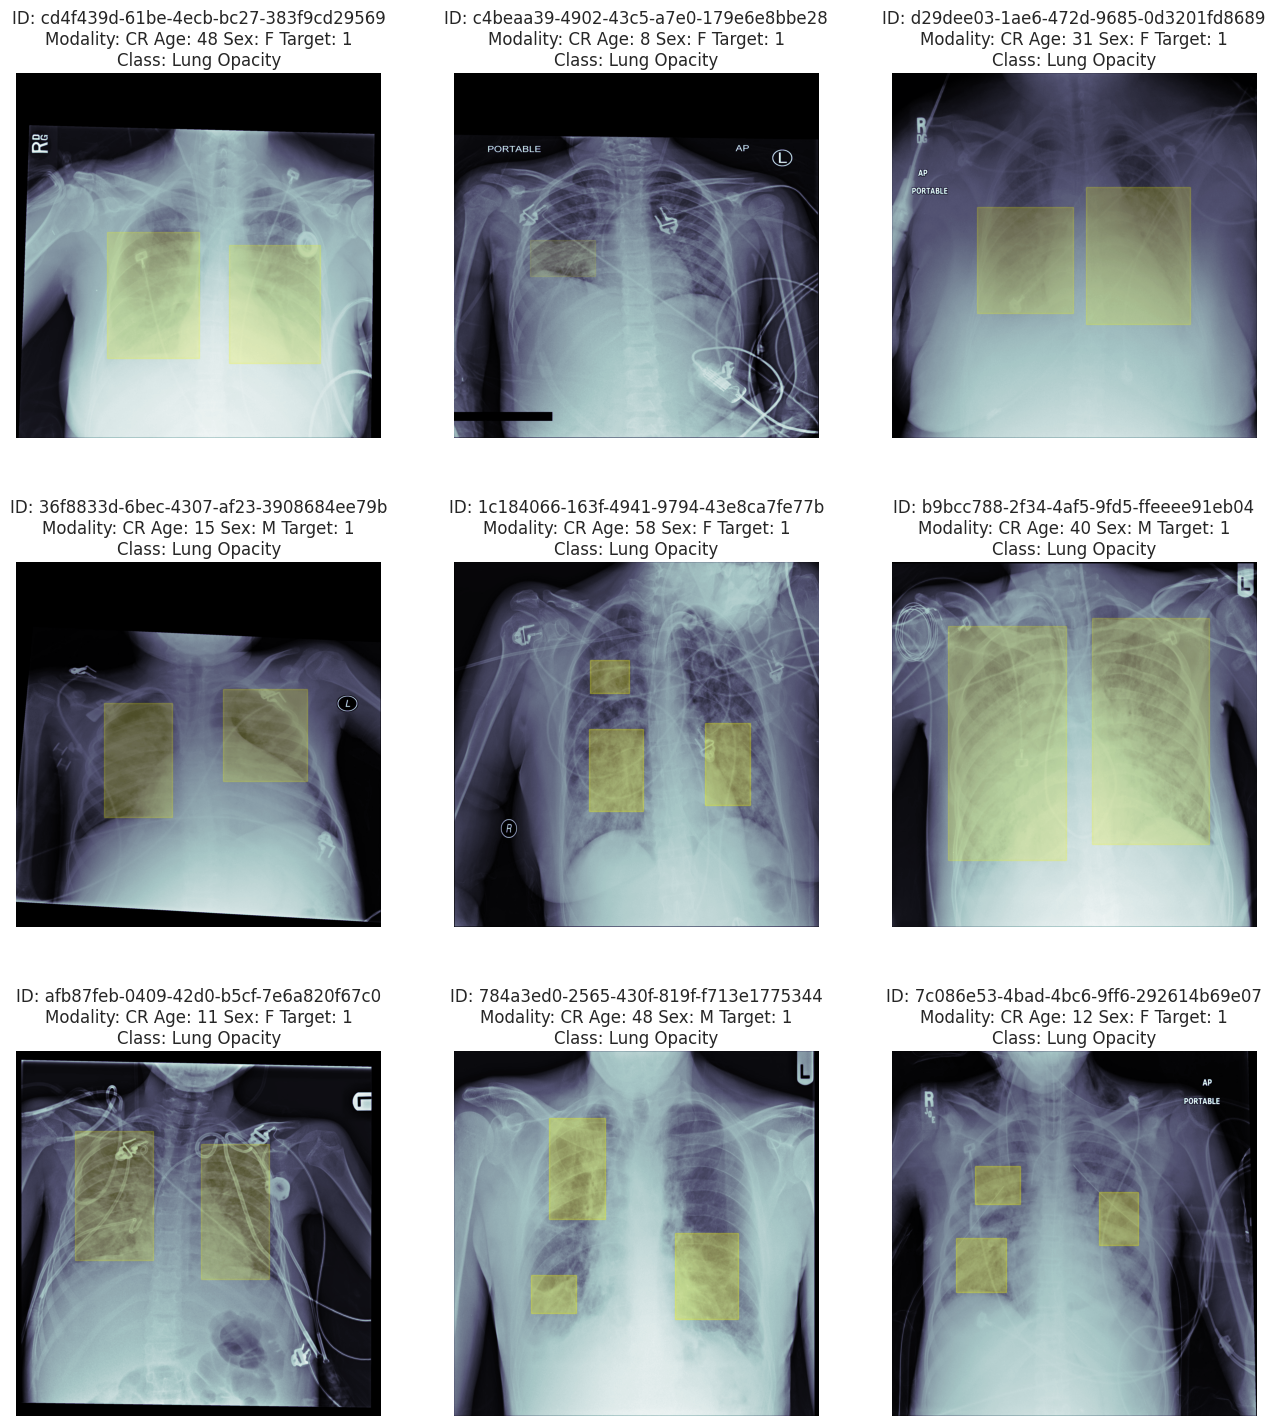

In [29]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

In [30]:
#For some of the images with Target=1, we might see multiple areas (boxes/rectangles) with Lung Opacity.

# Let's sample few images having the Target = 0.

# Plot DICOM images with Target = 0

In [ ]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

In [32]:
import os

dir_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images"

num_images = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
print(f"Number of images in directory: {num_images}")


Number of images in directory: 26704


In [33]:
import os

dir_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_test_images"

num_images = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
print(f"Number of images in directory: {num_images}")

Number of images in directory: 3000


In [34]:
!nvidia-smi

Fri May  5 06:44:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [36]:
# import pydicom
# from PIL import Image

# # Define input and output directories
# input_dir = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images"
# output_dir = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images"

# # Define new image size and mode
# new_size = (256, 256)
# new_mode = "L"  # L mode represents a grayscale image

# i = 0

# # Loop through DICOM files in input directory
# for filename in os.listdir(input_dir):
#     if filename.endswith(".dcm"):

#         # Load DICOM image
#         ds = pydicom.dcmread(os.path.join(input_dir, filename))
        
#         # Convert DICOM to PIL image
#         image = Image.fromarray(ds.pixel_array)
        
#         # Convert image to grayscale
#         image = image.convert(new_mode)
        
#         # Resize image
#         image = image.resize(new_size)
        
#         # Define output filename
#         output_filename = os.path.splitext(filename)[0] + ".png"
        
#         # Save image as PNG in output directory
#         output_path = os.path.join(output_dir, output_filename)
#         image.save(output_path, "PNG")

In [37]:
# # Define input and output directories
# input_dir = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_test_images"
# output_dir = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_test_png_images"

# # Define new image size and mode
# new_size = (256, 256)
# new_mode = "L"  # L mode represents a grayscale image

# i = 0

# # Loop through DICOM files in input directory
# for filename in os.listdir(input_dir):
#     if filename.endswith(".dcm"):

#         # Load DICOM image
#         ds = pydicom.dcmread(os.path.join(input_dir, filename))
        
#         # Convert DICOM to PIL image
#         image = Image.fromarray(ds.pixel_array)
        
#         # Convert image to grayscale
#         image = image.convert(new_mode)
        
#         # Resize image
#         image = image.resize(new_size)
        
#         # Define output filename
#         output_filename = os.path.splitext(filename)[0] + ".png"
        
#         # Save image as PNG in output directory
#         output_path = os.path.join(output_dir, output_filename)
#         image.save(output_path, "PNG")

In [38]:
import os

dir_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images"

num_images = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
print(f"Number of images in directory: {num_images}")

Number of images in directory: 26973


In [39]:
import os

dir_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_test_png_images"

num_images = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
print(f"Number of images in directory: {num_images}")

Number of images in directory: 3000


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the image dataframe
train_images_df = pd.read_csv('/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

# Split the dataframe into train and validation sets
train_df, test_df = train_test_split(train_images_df, test_size=0.1, random_state=42)

# Print the number of images in each set
print(f"Number of images in train set: {len(train_df)}")
print(f"Number of images in test set: {len(test_df)}")

Number of images in train set: 27204
Number of images in test set: 3023


In [67]:

# to delete any file or folder in drive
# import os

# directory = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/Aug-pneumonia'

# for filename in os.listdir(directory):
#     file_path = os.path.join(directory, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print(f"Failed to delete {file_path}. Reason: {e}")


In [ ]:
import os
import pandas as pd

# Define directories for train and validation data
train_dir = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images'
test_dir = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_test_png_images'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

# Get the unique patientId values from the DataFrame
unique_patientIds = df['patientId'].unique()
i = 0
# Loop through train and validation directories to check if patientId values are present in the DataFrame
for directory in [train_dir, test_dir]:
    for filename in os.listdir(directory):
        patientId = filename.split('.')[0]
        if patientId not in unique_patientIds:
            i = i+1
            print(f"{patientId} not found in DataFrame" + str(   i))

In [43]:
# import shutil
# import os

# subfolder_path = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/pneumonia'
# main_folder_path = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images'

# # Loop through files in the subfolder
# for filename in os.listdir(subfolder_path):
#     # Construct the full path to the file
#     file_path = os.path.join(subfolder_path, filename)
    
#     # Check if the file is a file (not a directory) and not a hidden file
#     if os.path.isfile(file_path) and not filename.startswith('.'):
#         # Move the file to the main folder
#         shutil.move(file_path, main_folder_path)

In [ ]:
# import os
# import shutil
# import pandas as pd

# # Define directories for train and validation data
# train_dir = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images'

# # Load the CSV file into a pandas DataFrame
# df = pd.read_csv('/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

# # Create train and validation directories for pneumonia and normal images
# train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')
# train_normal_dir = os.path.join(train_dir, 'normal')
# os.makedirs(train_pneumonia_dir, exist_ok=True)
# os.makedirs(train_normal_dir, exist_ok=True)

# # Loop through train directory and move images to appropriate directory
# for filename in os.listdir(train_dir):
#     patientId = filename.split('.')[0]
#     target = df.loc[df['patientId'] == patientId]['Target'].values[0]
#     try:
#         if target == 1:
#             shutil.move(os.path.join(train_dir, filename), os.path.join(train_pneumonia_dir, filename))
#         else:
#             shutil.move(os.path.join(train_dir, filename), os.path.join(train_normal_dir, filename))
#     except Exception as e:
#         print(f"Error occurred while processing {filename}: {str(e)}")


import os
import shutil
import pandas as pd

# Define directories for train and validation data
train_dir = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images'
test_dir = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_test_png_images'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

# Create train and validation directories for pneumonia and normal images
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')
train_normal_dir = os.path.join(train_dir, 'normal')
val_pneumonia_dir = os.path.join(test_dir, 'pneumonia')
val_normal_dir = os.path.join(test_dir, 'normal')
os.makedirs(train_pneumonia_dir, exist_ok=True)
os.makedirs(train_normal_dir, exist_ok=True)
os.makedirs(val_pneumonia_dir, exist_ok=True)
os.makedirs(val_normal_dir, exist_ok=True)

# Loop through train directory and move images to appropriate directory
for filename in os.listdir(train_dir):
    patientId = filename.split('.')[0]
    try:
        target = df.loc[df['patientId'] == patientId]['Target'].values[0]
        if target == 1:
            shutil.move(os.path.join(train_dir, filename), os.path.join(train_pneumonia_dir, filename))
        else:
            shutil.move(os.path.join(train_dir, filename), os.path.join(train_normal_dir, filename))
    except Exception as e:
        print(f"Error occurred while processing {filename}: {str(e)}")

# Loop through validation directory and move images to appropriate directory
for filename in os.listdir(test_dir):
    patientId = filename.split('.')[0]
    try:
        target = df.loc[df['patientId'] == patientId]['Target'].values[0]
        if target == 1:
            shutil.move(os.path.join(test_dir, filename), os.path.join(val_pneumonia_dir, filename))
        else:
            shutil.move(os.path.join(test_dir, filename), os.path.join(val_normal_dir, filename))
    except Exception as e:
        print(f"Error occurred while processing {filename}: {str(e)}")


In [70]:
import os

dir_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/Aug_Pneumonia"

num_images = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
print(f"Number of images in directory: {num_images}")

Number of images in directory: 0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

# define the path to the input and output directories
input_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/non-pneumonia"
output_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/Aug_Normal"

# create the output directory if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# define the augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=(30), 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')
kj = 0
# loop over the images in the input directory
for filename in os.listdir(input_path):
    # load the image from disk
    image = cv2.imread(os.path.join(input_path, filename))
    # apply the augmentation and save the image to disk
    for idx, batch in enumerate(datagen.flow(image.reshape(1, *image.shape), batch_size=1)):
        # get the augmented image
        augmented_image = batch[0].astype("uint8")
        # save the image to disk
        cv2.imwrite(os.path.join(output_path, f"{filename[:-4]}_{idx}.png"), augmented_image)
        # break out of the loop if we have generated the desired number of images
        kj += 1
        print(kj)
        if idx == 1:
            break


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

# define the path to the input and output directories
input_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/pneumonia"
output_path = "/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/Aug_Pneumonia"

# create the output directory if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# define the augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=(30), 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')
kj = 0
# loop over the images in the input directory
for filename in os.listdir(input_path):
    # load the image from disk
    image = cv2.imread(os.path.join(input_path, filename))
    # apply the augmentation and save the image to disk
    for idx, batch in enumerate(datagen.flow(image.reshape(1, *image.shape), batch_size=1)):
        # get the augmented image
        augmented_image = batch[0].astype("uint8")
        # save the image to disk
        cv2.imwrite(os.path.join(output_path, f"{filename[:-4]}_{idx}.png"), augmented_image)
        # break out of the loop if we have generated the desired number of images
        kj += 1
        print(kj)
        if idx == 1:
            break


In [58]:

# Define the source directory containing all the images
src_dir = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/normal'

# Define the destination directory for the selected images
dst_dir = '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_png_images/non-pneumonia'


import os
import shutil

# Define source and destination directories
russian = 6000
# Create destination directory if it doesn't exist
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

# Transfer the first 1000 images from source to destination directory
for count, filename in enumerate(os.listdir(src_dir)):
    if count < russian:
        src_file = os.path.join(src_dir, filename)
        dst_file = os.path.join(dst_dir, filename)
        shutil.copyfile(src_file, dst_file)

